In [ ]:
!pip uninstall -y eonacs && pip install  git+https://github.com/njnmco/smc #--log /dev/stderr

In [2]:
!pip install pacmap

     |████████████████████████████████| 646 kB 3.2 MB/s 
  Created wheel for annoy: filename=annoy-1.17.0-cp37-cp37m-linux_x86_64.whl size=391594 sha256=6c9d59fb276673d0319d4a5cf56c114dc4d3fc5575bb7279b0cb02ba64ae816b
  Stored in directory: /root/.cache/pip/wheels/4f/e8/1e/7cc9ebbfa87a3b9f8ba79408d4d31831d67eea918b679a4c07
Successfully built annoy


In [3]:
import eonacs.common.util as util

util.colab_map_drive()


Mounted at /content/drive


In [4]:
con = util.onet_db()

In [5]:
import pandas as pd
import numpy as np
import torch

In [37]:
tasks = pd.read_sql("select distinct substr(onetsoc_code, 1, 2) as soc,  task as text from task_statements",   con)
#dwa = pd.read_sql("select * from dwa_reference",   con)

In [38]:
tasks.head()

,soc,text
0,11,Direct or coordinate an organization's financi...
1,11,Appoint department heads or managers and assig...
2,11,Analyze operations to evaluate performance of ...
3,11,"Direct, plan, or implement policies, objective..."
4,11,"Prepare budgets for approval, including those ..."


In [22]:
pd.read_sql(""" SELECT 
    name
FROM 
    sqlite_master
WHERE 
    type ='table' AND 
    name NOT LIKE 'sqlite_%';
    """, con)

,name
0,skills
1,work_activities
2,dwa_reference
3,level_scale_anchors
4,career_starters_matrix
5,knowledge
6,abilities_to_work_activities
7,occupation_data
8,task_ratings
9,alternate_titles


In [29]:
print(pd.read_sql(""" 
SELECT 
    *
FROM 
    sqlite_master
WHERE 
    name = 'task_statements';
    """, con)['sql'][0])

CREATE TABLE task_statements (
  onetsoc_code CHARACTER(10) NOT NULL,
  task_id DECIMAL(8,0) NOT NULL,
  task CHARACTER VARYING(1000) NOT NULL,
  task_type CHARACTER VARYING(12),
  incumbents_responding DECIMAL(4,0),
  date_updated DATE NOT NULL,
  domain_source CHARACTER VARYING(30) NOT NULL,
  PRIMARY KEY (task_id),
  FOREIGN KEY (onetsoc_code) REFERENCES occupation_data(onetsoc_code))


In [8]:
from transformers import AutoModel
fine  = AutoModel.from_pretrained("/content/drive/MyDrive/smc/models/dbert_tasks/")
hyper = AutoModel.from_pretrained("/content/drive/MyDrive/smc/models/dbert_tasks_hyper/")

Some weights of the model checkpoint at /content/drive/MyDrive/smc/models/dbert_tasks/ were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /content/drive/MyDrive/smc/models/dbert_tasks_hyper/ were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'v

In [9]:
import eonacs.common.reduction as reduction

In [35]:
baseline_e = dbert.get_embeddings(tasks['text'], tokenizer, model)
fine_e = dbert.get_embeddings(tasks['text'], tokenizer, fine)
hyper_e = dbert.get_embeddings(tasks['text'], tokenizer, hyper)

Using cuda:0
0...
1024...
2048...
3072...
4096...
5120...
6144...
7168...
8192...
9216...
10240...
11264...
12288...
13312...
14336...
15360...
16384...
17408...
Using cuda:0
0...
1024...
2048...
3072...
4096...
5120...
6144...
7168...
8192...
9216...
10240...
11264...
12288...
13312...
14336...
15360...
16384...
17408...
Using cuda:0
0...
1024...
2048...
3072...
4096...
5120...
6144...
7168...
8192...
9216...
10240...
11264...
12288...
13312...
14336...
15360...
16384...
17408...


In [36]:
import plotnine as p9

In [49]:
scale, reducer, embedding = reduction.reduction(baseline_e)

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


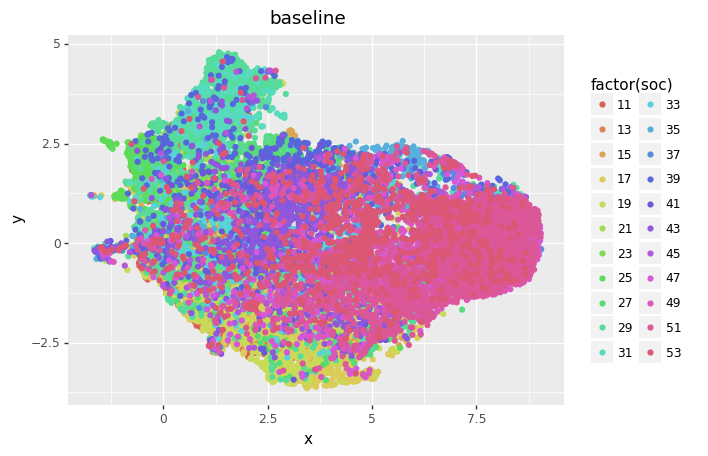

<ggplot: (8751721762297)>

In [51]:
df = pd.concat([tasks, pd.DataFrame(embedding, columns=['x','y']) ], axis=1)
(p9.ggplot(df) + 
   p9.aes(x='x', y='y', color='factor(soc)') + 
   p9.geom_point() +
   p9.ggtitle("baseline")
)

In [59]:
scale, reducer, embedding = reduction.reduction(fine_e)

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


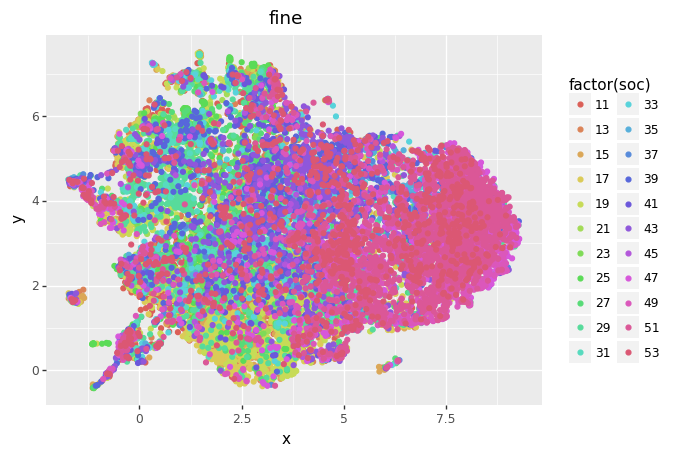

<ggplot: (8751719981869)>

In [60]:
df = pd.concat([tasks, pd.DataFrame(embedding, columns=['x','y']) ], axis=1)
(p9.ggplot(df) + 
   p9.aes(x='x', y='y', color='factor(soc)') + 
   p9.geom_point()+
   p9.ggtitle("fine")
)

In [61]:
scale, reducer, embedding = reduction.reduction(hyper_e)

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


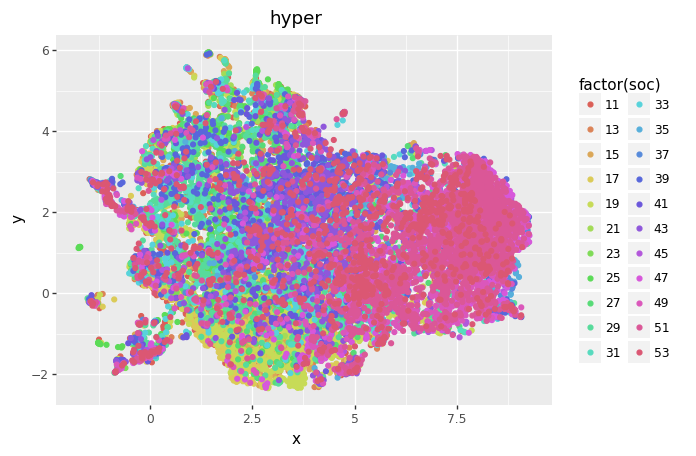

<ggplot: (8751721858633)>

In [62]:
df = pd.concat([tasks, pd.DataFrame(embedding, columns=['x','y']) ], axis=1)
(p9.ggplot(df) + 
   p9.aes(x='x', y='y', color='factor(soc)') + 
   p9.geom_point() + 
   p9.ggtitle("hyper")
)

In [66]:
import pacmap
from sklearn.preprocessing import StandardScaler

pmap = pacmap.PaCMAP(n_dims=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0) 


In [67]:
features = baseline_e
scale = StandardScaler()
features = scale.fit_transform(features)
pmap = pacmap.PaCMAP(n_dims=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0) 
embedding = pmap.fit_transform(features)

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


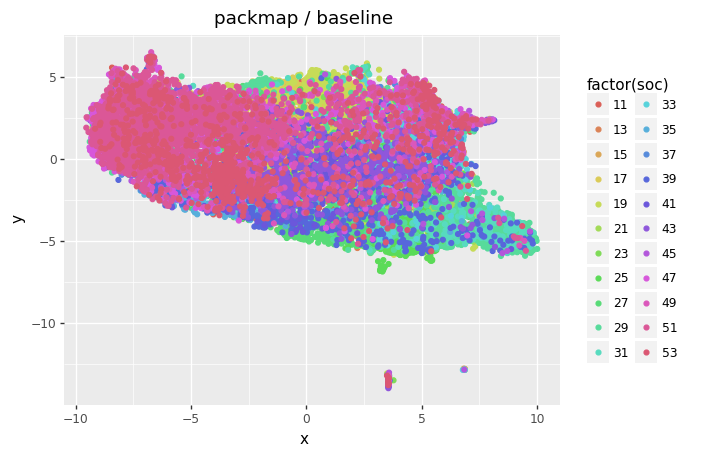

<ggplot: (8751719971169)>

In [68]:
df = pd.concat([tasks, pd.DataFrame(embedding, columns=['x','y']) ], axis=1)
(p9.ggplot(df) + 
   p9.aes(x='x', y='y', color='factor(soc)') + 
   p9.geom_point() +
   p9.ggtitle("packmap / baseline")
)

In [69]:
features = fine_e
scale = StandardScaler()
features = scale.fit_transform(features)
pmap = pacmap.PaCMAP(n_dims=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0) 
embedding = pmap.fit_transform(features)

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


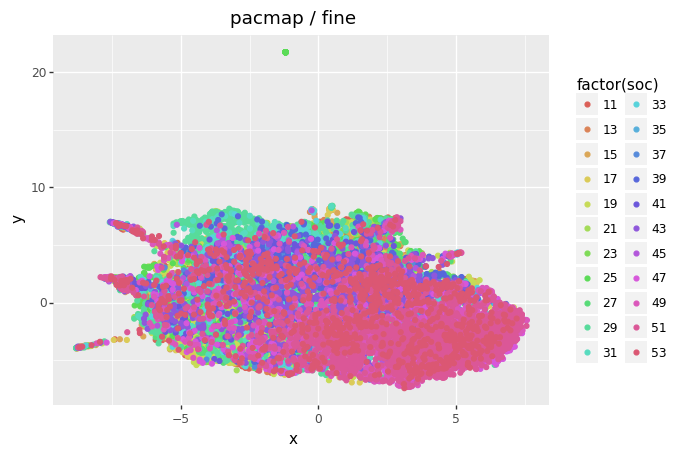

<ggplot: (8751718691665)>

In [71]:
df = pd.concat([tasks, pd.DataFrame(embedding, columns=['x','y']) ], axis=1)
(p9.ggplot(df) + 
   p9.aes(x='x', y='y', color='factor(soc)') + 
   p9.geom_point() +
   p9.ggtitle("pacmap / fine")
)

In [72]:
features = hyper_e
scale = StandardScaler()
features = scale.fit_transform(features)
pmap = pacmap.PaCMAP(n_dims=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0) 
embedding = pmap.fit_transform(features)

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


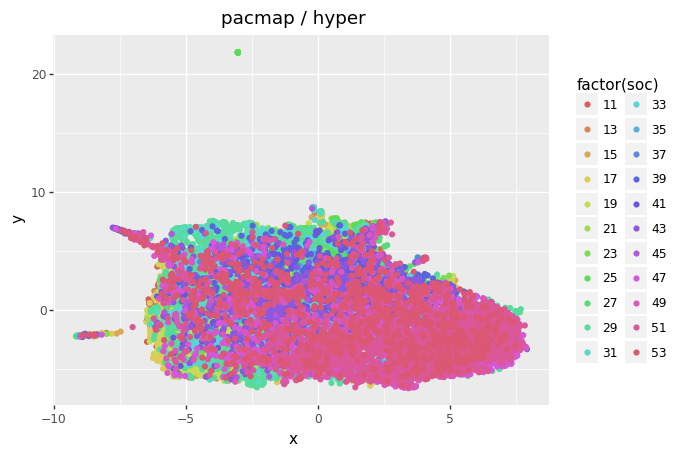

<ggplot: (8751720765893)>

In [74]:
df = pd.concat([tasks, pd.DataFrame(embedding, columns=['x','y']) ], axis=1)
(p9.ggplot(df) + 
   p9.aes(x='x', y='y', color='factor(soc)') + 
   p9.geom_point() +
   p9.ggtitle("pacmap / hyper")
)